*Project 1 - Machine Learning for NLP*

*Michele Pulvirenti, Marco Riva*

# **TripAdvisor raccomandation system**

In [ ]:
!pip install fast-langdetect --quiet
!pip install fastparquet --quiet
!pip install rank_bm25 --quiet
!pip install torch --quiet
!pip install transformers --quiet
!pip install kagglehub --quiet
!pip install nltk --quiet
!pip install sentence-transformers --quiet
!pip install matplotlib seaborn --quiet
!pip install gdown --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.3/786.3 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.9 MB/s eta 0:00:00


In [ ]:
import os
import random
import gdown
import pickle
import torch
import numpy as np
import pandas as pd
from pandas import json_normalize

import kagglehub
import zipfile

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from fast_langdetect import detect

from tqdm import tqdm

from rank_bm25 import BM25Okapi

from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer

### Data storing

In [ ]:
def is_running_on_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

is_running_on_colab()

True

In [ ]:
if is_running_on_colab():
    if False: # mount
      from google.colab import drive
      drive.mount('/content/drive')
      main_path = 'drive/MyDrive/Colab Notebooks/NLP/'
    else: # download
      ids = ['1ZeMGHJMKdrKAq-7EqNJqMf_S738BfTTp', '1MlTNu0OAqxI-YMn9bmKXDlQTeB8FLdOd', '16ehZ4t0YUzSOF7M6ACPc6gCgInc3xq0s',
             '1x4pxDSweRx-NQzpzimbb38sUBR2JsSbq', '1WeCslQB4ShPNROqIccv3xb-Bb5Nb3cXT', '14PK_SONi8Y-j9duhK2DRyM5DqjND6Kz9',
             '1UCpLf5v6w5KNqTDRCdWqYsVGa41Nb70y', '1KPh_o_ZPH3QJ09w-lbl-MJDKhpletsWT', '1KPh_o_ZPH3QJ09w-lbl-MJDKhpletsWT',
             '14wgK6iYSnyK-n_XRKPTbaw7GiYmMoepg', '1Z_ndRRtSBIB6SBjDS2_tHA1hy1D4cKS9', '1N669Y2HWPWezP4lsSCjL55mQ1VuJoWWQ',
             '1nRg-Nb6bCI8vbL3VOKO3eIPOUAIBJ3KZ', '1m_CO7MkZ272hkZyKnYiqI8bEkPHcxNq8', '1SbCqoy63BkLnGdgf2aKotFyPEvcDl6Vn',
             '1nPxoPpN-XpzE7wjXyjvyZgupa8LPRals', '1AG3F-_eobWG40B1vQIt_LbZQyVPBNx64', '1HExmdpzayMwk711UsVA7zuYAVBLP4jwZ']
      for id in ids:
        gdown.download(id=id)
      main_path = '/content/'
else:
    main_path = './'

Downloading...
From: https://drive.google.com/uc?id=1ZeMGHJMKdrKAq-7EqNJqMf_S738BfTTp
To: /content/BERT_embeddings.pkl
100%|██████████| 11.6M/11.6M [00:00<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MlTNu0OAqxI-YMn9bmKXDlQTeB8FLdOd
To: /content/BERT_results_0.pkl
100%|██████████| 2.04k/2.04k [00:00<00:00, 5.13MB/s]
Downloading...
From: https://drive.google.com/uc?id=16ehZ4t0YUzSOF7M6ACPc6gCgInc3xq0s
To: /content/BertNLI_embeddings.pkl
100%|██████████| 11.4M/11.4M [00:00<00:00, 68.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x4pxDSweRx-NQzpzimbb38sUBR2JsSbq
To: /content/BertNLI_results_0.pkl
100%|██████████| 2.04k/2.04k [00:00<00:00, 5.21MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WeCslQB4ShPNROqIccv3xb-Bb5Nb3cXT
To: /content/BM25_results_0.pkl
100%|██████████| 2.04k/2.04k [00:00<00:00, 5.50MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=14PK_SONi8Y-j9duhK2DRyM5DqjND6Kz9
From (redirected): https://drive.google.c

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cpu'

# DATA PREPARATION

### Download dataset

In [ ]:
dataset_filename = 'reviews.csv'

if not os.path.exists(main_path + dataset_filename): # Check if the file already exists
    cache_dataset_zipped = kagglehub.dataset_download("joebeachcapital/hotel-reviews", path=dataset_filename)
    # the file is actually downloaded as zipped, even if there is not '.zip' extensions so we need to extract it
    with zipfile.ZipFile(cache_dataset_zipped, 'r') as zip_ref:
        for file in zip_ref.namelist(): # Iterate through each file in the zip file
            if not os.path.exists(os.path.join(main_path, file)): # Check if the file already exists
                zip_ref.extract(file, main_path) # Extract the file
else:
    print(f"File '{dataset_filename}' already exists")

dataset_path = main_path + dataset_filename

File 'reviews.csv' already exists


In [ ]:
# reviews that have null values on relevant rating criteria
relevant_rating_columns = ['service', 'cleanliness', 'overall', 'value', 'location', 'sleep_quality', 'rooms']

def load_or_compute(df, name, fun): # utility function
    """
    Load the dataset if it exists, otherwise apply the wanted function and save it
    :param df: the already loaded dataset
    :param name: the name of the file to look for or save
    :param fun: the function to apply to the dataset
    :return: the loaded or computed dataset
    """
    path = main_path
    if os.path.exists(path + name):
        print("loading dataset")
        return pd.read_parquet(path + name)
    else:
        df = fun(df)
        print("computing and saving dataset")
        df.to_parquet(path + name, index=False)
        return df

### Import dataset

In [ ]:
df = pd.read_csv(main_path + 'reviews.csv')
df.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,2012-12-17,147643103,False
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,2012-12-17,147639004,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,2012-12-18,147697954,False
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",August 2012,1762573,0,2012-12-17,147625723,False
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",December 2012,1762573,0,2012-12-17,147612823,False


## Data formatting
### Flatten the json 'ratings' column
The values of **ratings** are json object as string.

### Remove unused columns and rows
In order to compare places accurately, we keep only the reviews with ratings only on relevant criteria, not more and not less.

In [ ]:
def clean_df(df):
    # FLATTEN - convert JSON column to DataFrame
    json_df = json_normalize(df.ratings.apply(eval))

    # merge the two dataframes
    df = df.drop(columns=['ratings']).join(json_df)

    # REMOVE COLUMNS - unused columns
    df.drop(columns=['title', 'author', 'date_stayed', 'num_helpful_votes', 'date', 'id', 'via_mobile'], inplace=True, errors='ignore')
    df.dropna(subset=relevant_rating_columns, inplace=True)
    # reviews that have more rating criteria than the relevant ones
    df = df[~df['check_in_front_desk'].notna()]
    df = df[~df['business_service_(e_g_internet_access)'].notna()]
    df.drop(columns=['check_in_front_desk', 'business_service_(e_g_internet_access)'], inplace=True, errors='ignore')
    return df

df = load_or_compute(df, 'reviews_clean.parquet', clean_df)
df

loading dataset


,text,offering_id,service,cleanliness,overall,value,location,sleep_quality,rooms
0,Stayed in a king suite for 11 nights and yes i...,93338,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,"On every visit to NYC, the Hotel Beacon is the...",93338,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,This is a great property in Midtown. We two di...,1762573,4.0,5.0,4.0,4.0,5.0,4.0,4.0
3,The Andaz is a nice hotel in a central locatio...,1762573,5.0,5.0,4.0,5.0,5.0,5.0,5.0
4,I have stayed at each of the US Andaz properti...,1762573,4.0,5.0,4.0,3.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...
436351,"Das Hotel Palomar gehoert zur Kimpton Gruppe, ...",84093,4.0,5.0,4.0,3.0,4.0,4.0,4.0
436352,Anlässlich einer Geschäftsreise waren wir das ...,84093,5.0,5.0,5.0,5.0,5.0,5.0,5.0
436353,"Das Hotel liegt in Arlington, eine etwas gehob...",84093,5.0,5.0,5.0,4.0,5.0,5.0,5.0
436354,Mon mari et moi sommes restés à l'hôtel du jeu...,84093,5.0,5.0,5.0,5.0,5.0,5.0,5.0


## Data processing
To obtain better results, some preprocessing techniques are applied such as: language detection, tokenization, lowercasing, removing puntualization, stopwords...

### Language detection
We have to check the language of all reviews.

#### Inspect

In [ ]:
# ensures no empty strings
print('empty reviews count:', df.text.apply(lambda x: x.strip() == '').sum())
df.isnull().sum()

empty reviews count: 0


,0
text,0
offering_id,0
service,0
cleanliness,0
overall,0
value,0
location,0
sleep_quality,0
rooms,0


In [ ]:
# assess the reviews are mostly long, therefore helping in language detection
short_len_def = 70
short_reviews_percentage = round((len(df[df['text'].str.len() < short_len_def]) / len(df)) * 100, 2)
print(f'short (less than {short_len_def} character long) reviews: {short_reviews_percentage}%')

short (less than 70 character long) reviews: 0.31%


#### Detect

#### Filter
Since the dataset is mostly in English (as shown in the following output), we can filter out the non-English reviews

In [ ]:
def detect_language(text):
    try:
        return detect(text.replace("\n", ""), low_memory=False)["lang"]
    except Exception:
        return 'unknown'

def remove_non_english_reviews(df):
    df['language'] = df['text'].apply(detect_language)
    # display the percentage of each language
    language_counts = df['language'].value_counts(normalize=True) * 100
    print(language_counts.to_dict())
    # keep only english reviews
    df = df[df['language'] == 'en']
    return df.drop(columns=['language'])

df = load_or_compute(df, 'reviews_clean_lan.parquet', remove_non_english_reviews)
df

loading dataset


,text,offering_id,service,cleanliness,overall,value,location,sleep_quality,rooms
0,Stayed in a king suite for 11 nights and yes i...,93338,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,"On every visit to NYC, the Hotel Beacon is the...",93338,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,This is a great property in Midtown. We two di...,1762573,4.0,5.0,4.0,4.0,5.0,4.0,4.0
3,The Andaz is a nice hotel in a central locatio...,1762573,5.0,5.0,4.0,5.0,5.0,5.0,5.0
4,I have stayed at each of the US Andaz properti...,1762573,4.0,5.0,4.0,3.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...
394367,We stayed four nights at the Hotel Palomar in ...,84093,5.0,5.0,5.0,5.0,5.0,5.0,5.0
394368,"The Palomar Hotel in Washington, DC is just of...",84093,5.0,5.0,5.0,5.0,5.0,5.0,5.0
394369,"When planning my visit to DC, I knew I would s...",84093,5.0,4.0,5.0,4.0,5.0,4.0,4.0
394370,I travel quiet often and not once have I ever ...,84093,5.0,5.0,5.0,5.0,5.0,5.0,5.0


### Group by offering_id
We then group the dataset by 'offering_id', concatenating the reviews related to the same business

In [ ]:
def group_by_offering_id(df):
    return df.groupby('offering_id').agg({
        'text': ' '.join,
        'service': 'mean',
        'cleanliness': 'mean',
        'overall': 'mean',
        'value': 'mean',
        'location': 'mean',
        'sleep_quality': 'mean',
        'rooms': 'mean'
    }).reset_index()

df_grouped = load_or_compute(df, 'grouped_reviews_clean_lan.parquet', group_by_offering_id)
df_grouped

loading dataset


,offering_id,text,service,cleanliness,overall,value,location,sleep_quality,rooms
0,72572,I had to make fast visit to seattle and I foun...,4.604061,4.634518,4.390863,4.324873,4.568528,4.329949,4.284264
1,72579,"Great service, rooms were clean, could use som...",4.247934,4.264463,3.892562,4.148760,4.206612,3.776860,3.876033
2,72586,Beautiful views of the space needle - especial...,4.261905,4.301587,4.071429,4.087302,4.587302,4.119048,4.015873
3,72598,This hotel is in need of some serious updates....,3.243243,3.243243,2.918919,3.054054,3.027027,3.270270,3.189189
4,73236,My experience at this days inn was perfect. th...,4.277778,3.111111,3.388889,3.777778,4.111111,3.722222,3.222222
...,...,...,...,...,...,...,...,...,...
3722,3513445,"New rooms, clean beds, bathroom. You have wifi...",3.666667,4.000000,3.666667,4.000000,3.000000,4.000000,3.666667
3723,3523356,I've stayed at plenty of Hampton Inns during m...,4.928571,4.928571,4.571429,4.214286,4.500000,4.571429,4.500000
3724,3541823,"Inn staff absolutely wonderful, helpful, knowl...",4.750000,4.500000,4.000000,4.500000,5.000000,3.750000,3.250000
3725,3572384,"Crowded, noisy, dirty. Service is poor, food i...",3.000000,2.000000,2.000000,2.000000,4.000000,3.000000,2.000000


## Transformations

In [ ]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    words = word_tokenize(text.lower())
    # removes punctuation
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return lemmatized_words

def preprocess_df(df):
    df_copy = df.copy()
    df['text'] = df_copy['text'].apply(preprocess)
    return df

df = load_or_compute(df, 'reviews_clean_lan_preproc.parquet', preprocess_df)

df_grouped = load_or_compute(df_grouped, 'grouped_reviews_clean_lan_preproc.parquet', preprocess_df)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


loading dataset
loading dataset


# MODEL TESTING
This section actually defines the model used in this notbook, among with their evaluations.
each model's codeblock outputs the average MSE obtained by running the model on the defined queries.

### Utility functions
Definition of some utility functions used across different models.

In [ ]:
seed = 0

def offering_index(df, offering_id):
    if offering_id not in df['offering_id'].values:
        RuntimeError(f"id {offering_id} not found. Is this the correct dataset?")
    return df[df['offering_id'] == offering_id].index[0]

def drop_tokenize_df(df, offering_id):
    df_edited = df.drop(index=offering_index(df, offering_id), inplace=False)
    return df_edited['text'].tolist(), df_edited

def offering_text(df, offering_id):
    return df['text'][offering_index(df, offering_id)]
def offering_ratings(df, offering_id):
    return df.iloc[offering_index(df, offering_id)][relevant_rating_columns]

In [ ]:
def entry_text(df, index):
    """
    Get the text of the entry at the given index
    """
    return df['text'][index]

def entry_ratings(df, index):
    """
    Get the set of relevant ratings of the entry at the given index
    """
    return df.iloc[index][relevant_rating_columns]

def remove_offering(df, offering_id):
    """
    Remove the offering from the dataset
    :param df: the dataset to remove the offering from
    :param offering_id: the id of the offering to remove
    :return: the dataset without the offering
    """
    return df.drop(index=offering_index(df, offering_id), inplace=False).reset_index(drop=True)

def retrieve_best_offering(df, scores):
    """
    Retrieve the best offering_id from the scores
    """
    if len(df) != len(scores):
        RuntimeError("Wrong dataset (len of df and scores differs)")
    return df.iloc[np.argmax(scores)]['offering_id']

def prepare(model_feed, df, index, df_grouped):
    """
    Prepare the model input and the dataset without the review
    :param model_feed: model's functions to feed the model
    :param df: the full dataset
    :param index: the index of the review
    :param df_grouped: the grouped dataset
    :return: the tokenized model input (using the provided function) and the grouped dataset without the review
    """
    query_offering_id = df['offering_id'][index]
    removed_df = remove_offering(df_grouped, query_offering_id)
    return model_feed(removed_df['text'].tolist()), removed_df

def compute_best_offering(model_fun, df, index, df_removed):
    review_text = df['text'][index]
    scores = model_fun(review_text)
    return retrieve_best_offering(df_removed, scores)

def compute_mse(df, df_removed, index, best_offering):
    """
    Compute the MSE of the review
    :param df: the full dataset
    :param df_removed: the grouped dataset without the review
    :param index: the index of the review
    :param best_offering: the best offering_id computed
    :return: the MSE of the review
    """
    return mean_squared_error(entry_ratings(df, index), entry_ratings(df_removed, offering_index(df_removed, best_offering)))

def save_results(model_name, mses, off_ids):
    """
    Save the results of the model
    :param model_name: the name of the model
    :param mses: the list of MSEs
    :param off_ids: the list of best offering_ids
    """
    with open(main_path + f"{model_name}_results_{seed}.pkl", "wb") as f:
        pickle.dump((mses, off_ids), f)

def load_results(model_name):
    """
    Load the results of the model
    :param model_name: the name of the model
    :return: the list of MSEs and the list of best offering_ids
    """
    with open(main_path + f"{model_name}_results_{seed}.pkl", "rb") as f:
        return pickle.load(f)

def load_or_compute(name, fun, args):
    """
    Load the results of the model if they exist, otherwise compute them
    :param name: the name of the model
    :param fun: the function to run the model
    :param args: the arguments to pass to the function
    :return: the list of MSEs and the list of best offering_ids
    """
    path = main_path
    if os.path.exists(path + f"{name}_results_{seed}.pkl"):
        print("loading results")
        return load_results(name)
    else:
        print("computing results")
        mses, offerings = fun(*args)
        save_results(name, mses, offerings)
        return mses, offerings

### Definition of queries
Here a sample of 50 reviews is randomly chosen across the entire dataset.
Tese 50 reviews are fixed and summited equally to all the running models.

In [ ]:
num_queries = 50
random.seed(seed)
indexes = random.sample(range(len(df)), num_queries)

## BM25
Implementation of the BM25 baseline.

In [ ]:
def run_BM25_query(df, df_grouped, index, model_feed):
    """
    Computes the score for a review on the given model and computes its MSE
    :param df: the full dataset
    :param df_grouped: the grouped dataset
    :param index: the index of the review
    :param model_feed: model's functions to feed the model
    :return: the MSE of the review
    """
    model, df_removed = prepare(model_feed, df, index, df_grouped)
    best_offering = compute_best_offering(model.get_scores, df, index, df_removed)
    return compute_mse(df, df_removed, index, best_offering), best_offering

def run_BM25_queries(df, df_grouped, indexes, model_feed):
    """
    Runs run_query(...) for specified reviews in the dataset
    :return: the list of MSEs
    """
    results = [run_BM25_query(df, df_grouped, i, model_feed) for i in tqdm(indexes, desc="Running queries")]
    mses = [mse for mse, off_id in results]
    off_ids = [off_id for mse, off_id in results]
    return mses, off_ids

mses, off_ids = load_or_compute("BM25", run_BM25_queries, (df, df_grouped, indexes, BM25Okapi))

print(f"Mean MSE: {np.mean(mses)}")

loading results
Mean MSE: 1.3343945740597833


## BERT
Implementation of the BERT model.

In [ ]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode a text into a BERT embedding
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of the last hidden states as the embedding
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Precompute embeddings for all places
def precompute_embeddings(df_grouped, embedding_file="BERT_embeddings.pkl"):
    path = main_path + embedding_file
    # Check if embeddings already exist on disk
    if os.path.exists(path):
        with open(path, "rb") as f:
            embeddings = pickle.load(f)
        print(f"Loaded {len(embeddings)} embeddings.")
        return embeddings

    # Compute embeddings if they don't exist
    embeddings = []
    for review in tqdm(df_grouped['text'], desc="Encoding reviews"):
        embeddings.append(get_bert_embedding(review))

    # Save embeddings to disk
    with open(path, "wb") as f:
        pickle.dump(embeddings, f)

    return embeddings

# Find the most similar place for a given query
def find_most_similar_place(query_embedding, embeddings):
    similarities = [cosine_similarity([query_embedding], [doc_emb])[0][0] for doc_emb in embeddings]
    most_similar_idx = torch.argmax(torch.tensor(similarities)).item()
    return most_similar_idx

# Full function to recommend the most similar place
def recommend_place(df, df_grouped, query_idx, embeddings):
    query_text = entry_text(df, query_idx)
    query_offering_id = df['offering_id'][query_idx]
    df_grouped_index = offering_index(df_grouped, query_offering_id)
    query_embedding = get_bert_embedding(query_text)

    # Exclude the query place itself
    filtered_embeddings = embeddings[:df_grouped_index] + embeddings[df_grouped_index + 1:]
    most_similar_idx = find_most_similar_place(query_embedding, filtered_embeddings)

    # Adjust index to account for exclusion of the query itself
    if most_similar_idx >= query_idx:
        most_similar_idx += 1
    return df_grouped.iloc[most_similar_idx]['offering_id']

def run_BERT_query(df, df_grouped, index, model_feed):
    best_offering_id = recommend_place(df, df_grouped, index, model_feed)
    return mean_squared_error(entry_ratings(df, index), entry_ratings(df_grouped, offering_index(df_grouped, best_offering_id))), best_offering_id

def run_BERT_queries(df, df_grouped, indexes, model_feed):
    results = [run_BERT_query(df, df_grouped, i, model_feed) for i in tqdm(indexes, desc="Running queries")]
    mses = [mse for mse, off_id in results]
    off_ids = [off_id for mse, off_id in results]
    return mses, off_ids

df = pd.read_parquet(main_path + 'reviews_clean_lan.parquet')
df_grouped = pd.read_parquet(main_path + 'grouped_reviews_clean_lan.parquet')

mses_uncased, off_ids_uncased = load_or_compute("BERT", run_BERT_queries, (df, df_grouped, indexes, precompute_embeddings(df_grouped)))

print(f"Mean MSE: {np.mean(mses_uncased)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loaded 3727 embeddings.
loading results
Mean MSE: 1.5956278574004725


## Other models
Trying SentenceTransformer with different models

In [ ]:
def get_embeddings_in_batches(model, texts, batch_size=32):
    texts = [str(text) for text in texts]
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batch_embeddings = model.encode(batch, convert_to_tensor=False)
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

def compute_mse(df, df_removed, index, best_offering):
    return mean_squared_error(entry_ratings(df, index), entry_ratings(df_removed, offering_index(df_removed, best_offering)))

def retrieve_best_offering(df, scores):
    if len(df) != len(scores):
        raise RuntimeError("Length of df and scores differ")
    return df.iloc[np.argmax(scores)]['offering_id']

def compute_similarity(embeddings, query_embedding):
    return cosine_similarity(embeddings, query_embedding.reshape(1, -1)).flatten()

def normalize_embeddings(embeddings):
    return normalize(embeddings, axis=1, norm='l2')

def precompute_embeddings(df_grouped, model, model_name, batch_size=128):
    texts = df_grouped['text'].tolist()

    embedding_file = model_name + "_embeddings.pkl"
    path = main_path + embedding_file
    if os.path.exists(path):
        with open(path, "rb") as f:
            embeddings = pickle.load(f)
        print(f"Loaded {len(embeddings)} embeddings.")
    else:
        embeddings = normalize(get_embeddings_in_batches(model, texts, batch_size))

        with open(path, "wb") as f:
            pickle.dump(embeddings, f)
    return embeddings, df_grouped['offering_id'].values

def precompute_query_embeddings(df, indexes, model):
    texts = [df['text'][i] for i in indexes]
    return normalize(model.encode(texts, convert_to_tensor=False))

def run_bert_queries_optimized(df, df_grouped, indexes, model, model_name):
    embeddings, offering_ids = precompute_embeddings(df_grouped, model, model_name)
    query_embeddings = precompute_query_embeddings(df, indexes, model)
    mses = []
    off_ids = []
    for query_idx, query_embedding in tqdm(zip(indexes, query_embeddings), desc="Running queries"):
        removed_indices = offering_ids != df['offering_id'][query_idx]
        removed_embeddings = embeddings[removed_indices]
        removed_offering_ids = offering_ids[removed_indices]

        scores = compute_similarity(removed_embeddings, query_embedding)
        best_offering = retrieve_best_offering(pd.DataFrame({'offering_id': removed_offering_ids}), scores)
        mse = compute_mse(df, df_grouped, query_idx, best_offering)
        mses.append(mse)
        off_ids.append(best_offering)
    return mses, off_ids


# Sentence Transformer models

### MiniLM

In [ ]:
model_name = "MiniLM"
model = SentenceTransformer('all-MiniLM-L12-v2', device=device)

mses_minilm, off_ids_minilm = load_or_compute(model_name, run_bert_queries_optimized, (df, df_grouped, indexes, model, model_name))

print(f"Mean MSE: {np.mean(mses_minilm)}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

loading results
Mean MSE: 1.2607153867872507


### Bert NLI

In [ ]:
model_name = "BertNLI"
model = SentenceTransformer('bert-base-nli-mean-tokens', device=device)

mses_bert, off_ids_bert = load_or_compute(model_name, run_bert_queries_optimized, (df, df_grouped, indexes, model, model_name))

print(f"Mean MSE: {np.mean(mses_bert)}")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

loading results
Mean MSE: 1.0809636991631753


### MPNET

In [ ]:
model_name = "MPNET"
model = SentenceTransformer('all-mpnet-base-v2', device=device)

mses_mpnet, off_ids_mpnet = load_or_compute(model_name, run_bert_queries_optimized, (df, df_grouped, indexes, model, model_name))

print(f"Mean MSE: {np.mean(mses_mpnet)}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

loading results
Mean MSE: 1.0245606294825946


### Roberta

In [ ]:
model_name = "Roberta"
model = SentenceTransformer('roberta-large-nli-stsb-mean-tokens', device=device)

mses_roberta, off_ids_roberta = load_or_compute(model_name, run_bert_queries_optimized, (df, df_grouped, indexes, model, model_name))

print(f"Mean MSE: {np.mean(mses_roberta)}")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

loading results
Mean MSE: 0.8599210425245729


# EVALUATION
This section is dedicated to the evaluation of the models.
It prints the MSE values obtained by running the models on the defined queries and then the mean of these values per each model, in order to show the best one.

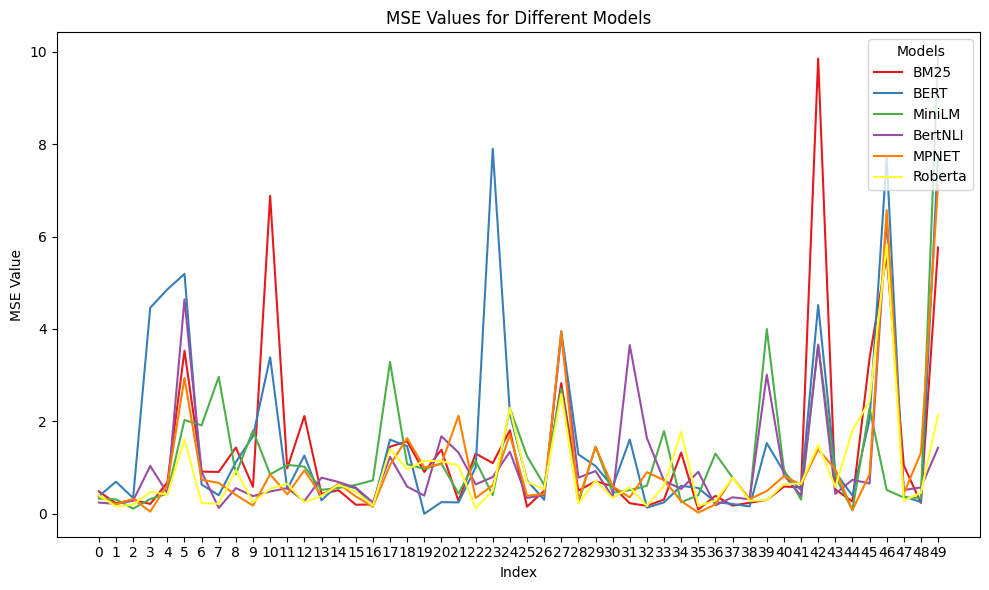

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['BM25', 'BERT', 'MiniLM', 'BertNLI', 'MPNET', 'Roberta']
mse_values = [mses, mses_uncased, mses_minilm, mses_bert, mses_mpnet, mses_roberta]

plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set1", n_colors=len(models))
num = list(range(num_queries))

for i, model in enumerate(models):
    plt.plot(num, mse_values[i], label=model, color=colors[i])

plt.title("MSE Values for Different Models")
plt.xlabel("Index")
plt.ylabel("MSE Value")
plt.xticks(range(len(indexes)))
plt.legend(title="Models", loc="upper right")

plt.tight_layout()
plt.show()

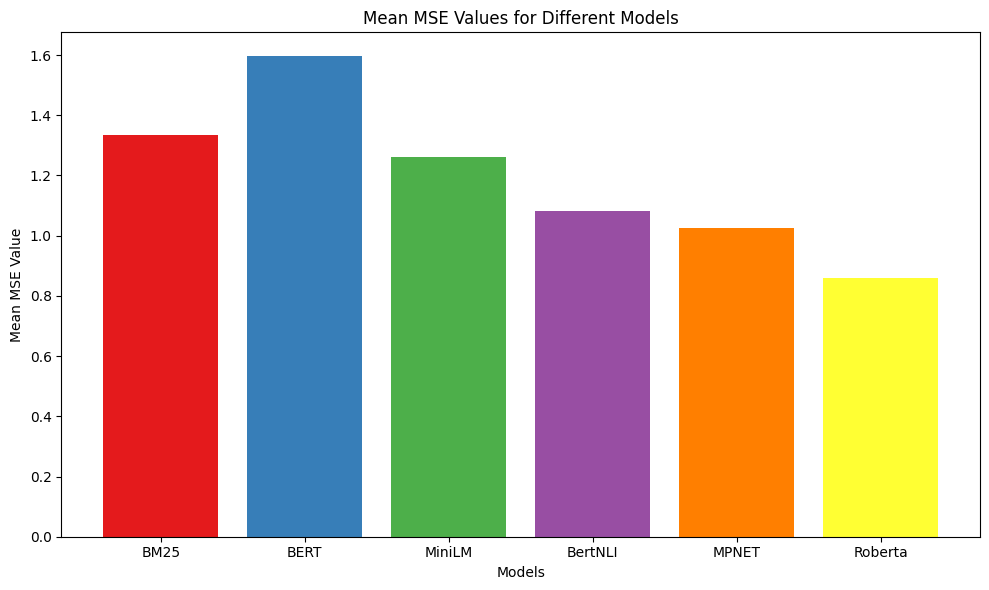

In [ ]:
means = [np.mean(mse) for mse in mse_values]

plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set1", n_colors=len(models))

plt.bar(models, means, color=colors)

plt.title("Mean MSE Values for Different Models")
plt.xlabel("Models")
plt.ylabel("Mean MSE Value")

plt.tight_layout()
plt.show()

# Ensamble Learning

In [ ]:
off_id_values = [off_ids, off_ids_uncased, off_ids_minilm, off_ids_bert, off_ids_mpnet, off_ids_roberta]

results = {}

for i in range(num_queries):
  mses_query = [x[i] for x in mse_values]
  min_mse = min(mses_query)
  min_mse_pos = mses_query.index(min_mse)
  min_offid = off_id_values[min_mse_pos][i]
  model = models[min_mse_pos]
  query_id = df['offering_id'][indexes[i]]
  results[i] = {"offering_id": query_id, "suggested_offering_id": min_offid, "model": model, "mse": min_mse}

results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

,offering_id,suggested_offering_id,model,mse
0,99441,223713,BertNLI,0.243449
1,93340,3432111,Roberta,0.158289
2,93517,630950,MiniLM,0.112220
3,111507,1516481,MPNET,0.048106
4,115617,80771,Roberta,0.414740
5,112328,99051,Roberta,1.607143
6,1027494,99535,Roberta,0.234118
7,1858565,73445,BertNLI,0.126701
8,81212,1134288,MPNET,0.408223
9,556822,100556,MPNET,0.178571


In [ ]:
results_df['model'].value_counts()

,count
model,
Roberta,11
BertNLI,9
BERT,9
BM25,8
MPNET,7
MiniLM,6
